# Data Loading and Preprocessing

In [1]:
from autoencoder import *
import glob
from IPython.display import Audio

2022-12-05 14:12:23.263205: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 14:12:23.289216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 14:12:23.289229: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_audio(filepaths, num_vectors=100, sr=22050):
    """
    Currently really slow: approximately 34 files read per second, but there are
    over 100,000 files
    """
    zipped_fname = f"raw_audio_{sr}.zip"
    audio_fname = f"raw_audio_{sr}.npy"
    audio = []
    np.random.shuffle(filepaths)
    start = time.time()
    random_indices = [i for i in range(num_vectors)]
    np.random.shuffle(random_indices)
    '''with ProcessPoolExecutor(max_workers=3) as exe:
        completed = exe.map(get_single_file, filepaths[:num_vectors], repeat(sr), chunksize=40)
        for item in completed:
            if item.shape[0] == sr:
                audio.append(item)'''
    if os.path.isfile(zipped_fname):
        with zipfile.ZipFile(zipped_fname, "r") as zip_ref:
            with zip_ref.open(audio_fname) as unzipped:
                audio = np.load(unzipped)
                print(time.time() - start)
                return audio[random_indices]
    for i, path in enumerate(filepaths):
        if i >= num_vectors:
            break
        X, sample_rate = librosa.load(path, sr=sr)
        if X.shape[0] != sample_rate:
            X = librosa.util.fix_length(X, size=sr)
        audio.append(X)
    print(time.time() - start)
    with zipfile.ZipFile(zipped_fname, "w") as zip_ref:
        np.save(audio_fname.replace(".npy", ""), audio)
        zip_ref.write(audio_bfname)
    return np.array(audio, dtype=np.float32)[random_indices]

In [3]:
sr = 22050
filepaths = get_all_files("wav")
audio = get_audio(filepaths, num_vectors=3000, sr=sr)

0.40653538703918457


In [4]:
def conv_data(audio, sr, mels=64):
    ### Long operation: convert raw audio to melspectrogram
    start = time.time()
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=mels)
    db = librosa.amplitude_to_db(mel, ref=np.max)
    print(time.time() - start)
    ### Reshape mel spectrogram so each [row][col] is a singleton array (for keras)
    db = db.reshape(*db.shape, 1) # This may not be a good idea

    X_train, X_test = train_test_split(db, test_size=0.3)
    return X_train, X_test

In [5]:
X_train, X_test = conv_data(audio, sr, mels=200)

3.268289566040039


# Audio Visualization

In [7]:
Audio(audio[0], rate=sr)

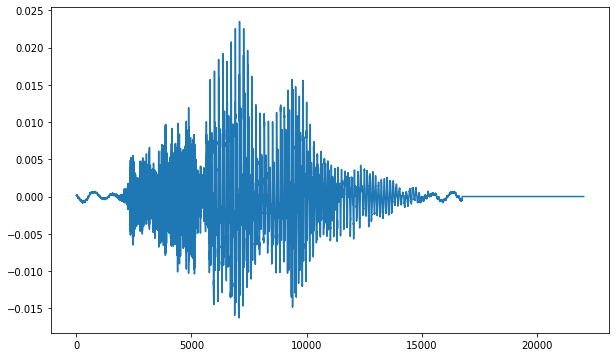

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(audio[0])

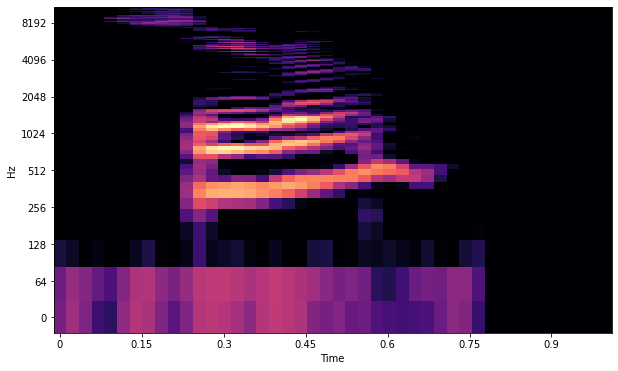

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
index = np.random.randint(0, len(audio))
mel = librosa.feature.melspectrogram(y=audio[0], sr=sr, n_mels=200)
mel_to_db = librosa.amplitude_to_db(mel, ref=np.max)
librosa.display.specshow(mel_to_db, x_axis="time", y_axis="log", ax=ax)
reshaped = mel.reshape(*mel.shape, 1)
fig.savefig("asdf.png")

# Get Convolutional Model

In [10]:
def get_conv_model(input_shape):
    Input = tf.keras.Input(shape=input_shape)
    #encoder = Sequential()
    x = layers.Conv2D(32, (3, 3), activation="leaky_relu", padding="same", input_shape=input_shape)(Input)
    x = layers.MaxPool2D((2, 2), padding="same")(x)
    x = layers.Conv2D(16, (3, 3), activation="leaky_relu", padding="same")(x)
    #print(encoder.summary())
    #latent = encoder(Input)
    #decoder = Sequential()
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="leaky_relu", padding="same")(x)
    x = layers.Conv2D(1, (1, 1), activation="linear")(x)
    print(x.shape)
    #print(decoder.summary())

    model = Model(inputs=Input, outputs=x)
    print(model.summary())
    model.compile(optimizer="adam", loss="MSE")
    return model

In [11]:
latent = 1000
print(X_train.shape[1:])
model = get_conv_model(X_train.shape[1:])

(200, 44, 1)
(None, 200, 44, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 44, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 44, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 22, 16)       4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 200, 44, 32)      4640      
 nspose)                                                         
                                                                 
 conv2d_2 (Conv2D)           

2022-12-05 14:12:59.863703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-05 14:12:59.863731: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 14:12:59.863755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jonaz-17Z90N-R-AAC8U1): /proc/driver/nvidia/version does not exist
2022-12-05 14:12:59.864039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/13
39/40 [============================>.] - ETA: 0s - loss: 1492.2151

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 120ms/step - loss: 1479.2266 - val_loss: 135.6167
Epoch 2/13
39/40 [============================>.] - ETA: 0s - loss: 109.2696

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 118ms/step - loss: 108.9946 - val_loss: 81.2818
Epoch 3/13
39/40 [============================>.] - ETA: 0s - loss: 63.7608

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 121ms/step - loss: 63.5934 - val_loss: 46.7149
Epoch 4/13
39/40 [============================>.] - ETA: 0s - loss: 36.2132

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 126ms/step - loss: 36.1242 - val_loss: 28.2932
Epoch 5/13
40/40 [==============================] - ETA: 0s - loss: 24.4476

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 6s 146ms/step - loss: 24.4476 - val_loss: 21.3174
Epoch 6/13
39/40 [============================>.] - ETA: 0s - loss: 18.3340

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 127ms/step - loss: 18.2925 - val_loss: 15.1535
Epoch 7/13
39/40 [============================>.] - ETA: 0s - loss: 12.2886

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 127ms/step - loss: 12.2885 - val_loss: 9.8569
Epoch 8/13
40/40 [==============================] - ETA: 0s - loss: 8.1026

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 134ms/step - loss: 8.1026 - val_loss: 6.9314
Epoch 9/13
39/40 [============================>.] - ETA: 0s - loss: 6.2029

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 132ms/step - loss: 6.2026 - val_loss: 5.7852
Epoch 10/13
39/40 [============================>.] - ETA: 0s - loss: 5.3877

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 137ms/step - loss: 5.3814 - val_loss: 5.1700
Epoch 11/13
39/40 [============================>.] - ETA: 0s - loss: 4.8435

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 137ms/step - loss: 4.8404 - val_loss: 4.6825
Epoch 12/13
39/40 [============================>.] - ETA: 0s - loss: 4.3901

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 132ms/step - loss: 4.3792 - val_loss: 4.2330
Epoch 13/13
40/40 [==============================] - ETA: 0s - loss: 3.9922

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 6s 150ms/step - loss: 3.9922 - val_loss: 3.8857


(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:title={'center':'mel_22050_1000_MSE'}, xlabel='epoch', ylabel='loss'>)

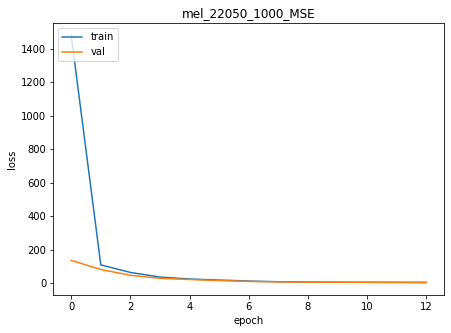

In [12]:
model_name = f"mel_{sr}_{latent}_{model.loss}"
checkpoint_callback = get_checkpoint(model_name)
history = model.fit(X_train, X_train, epochs=13, batch_size=48, shuffle=True, callbacks=[checkpoint_callback], validation_split=0.1)
plot_history(model_name, history, "loss")

# Predict and Convert to Audio

In [13]:
model = tf.keras.models.load_model("models/mel_22050_1000_MSE/")
pred = model.predict(X_test)

29/29 [==============================] - 1s 30ms/step


# Compare Spectrograms of Predicted vs. Actual

In [14]:
reshaped_pred = pred.reshape(pred.shape[:-1])
reshaped_actual = X_test.reshape(X_test.shape[:-1])

## Spectrogram Stats

In [20]:
pred_mean = np.mean(reshaped_pred, axis=0)
actual_mean = np.mean(reshaped_actual, axis=0)
pred_min = np.min(reshaped_pred, axis=0)
actual_min = np.min(reshaped_actual, axis=0)
pred_max = np.max(reshaped_pred, axis=0)
actual_max = np.max(reshaped_actual, axis=0)
print(pred_mean)
print(actual_mean)
print(pred_min)
print(actual_min)
print(pred_max)
print(actual_max)

[[-51.644302 -71.02383  -77.06425  ... -79.86719  -71.398895 -65.39971 ]
 [-73.96785  -75.25521  -84.293526 ... -83.95829  -74.47789  -72.36385 ]
 [-76.049576 -81.598595 -83.50397  ... -82.55105  -78.15596  -77.35625 ]
 ...
 [-81.4809   -82.822945 -80.132866 ... -81.43405  -81.007866 -81.60089 ]
 [-76.238686 -72.89751  -79.94825  ... -80.828995 -79.30473  -76.96949 ]
 [-62.670746 -68.71876  -76.62425  ... -78.847145 -76.08506  -71.409225]]
[[-79.189186 -78.3863   -78.27204  ... -79.9982   -80.       -80.      ]
 [-79.14941  -78.426544 -78.38113  ... -79.99522  -79.99777  -80.      ]
 [-79.68553  -79.82752  -79.94294  ... -80.       -80.       -80.      ]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]
[[-52.573418 -72.27214  -79.54984  ... -79.93412  -71.432625 -65.41913 ]
 [-75.18857  -76.87512  -86.787605 ... 

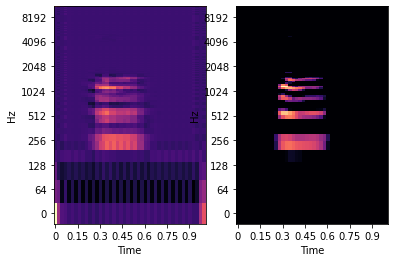

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
index = np.random.randint(0, len(reshaped_pred))
librosa.display.specshow(reshaped_pred[index], x_axis="time", y_axis="log", ax=ax1)
librosa.display.specshow(reshaped_actual[index], x_axis="time", y_axis="log", ax=ax2)
fig.savefig("asdf.png")


In [32]:
amp_pred = librosa.db_to_amplitude(reshaped_pred[index])
amp_actual = librosa.db_to_amplitude(reshaped_actual[index])
audio_pred = librosa.feature.inverse.mel_to_audio(amp_pred, sr=sr)
audio_actual = librosa.feature.inverse.mel_to_audio(amp_actual, sr=sr)

In [34]:
Audio(audio_pred, rate=sr)

In [5]:
mel = librosa.feature.melspectrogram(y=audio[0], sr=sr, n_mels=128)
db = librosa.amplitude_to_db(mel, np.max)
amp = librosa.db_to_amplitude(db)
out = librosa.feature.inverse.mel_to_audio(amp, sr=sr)
Audio(out, rate=sr)

/tmp/ipykernel_107882/4145550868.py:2: FutureWarning: Pass ref=<function amax at 0x7f27dc155f70> as keyword args. From version 0.10 passing these as positional arguments will result in an error
  db = librosa.amplitude_to_db(mel, np.max)


# Get mel/audio pairs (train/test)

In [6]:
n_mels = 128
mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)

# Use db Melspectrograms to determine original audio

In [4]:
def mel_to_audio_model(input_shape, sr):
    Input = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="leaky_relu", padding="same", input_shape=input_shape)(Input)
    x = layers.MaxPool2D((2, 2), padding="same")(x)
    x = layers.BatchNormalization(-1)(x)
    x = layers.Conv2D(32, (3, 3), activation="leaky_relu", padding="same")(x)
    x = layers.MaxPool2D((2, 2), padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(sr, activation="linear")(x)
    model = Model(inputs=Input, outputs=x)
    model.compile(optimizer="adam", loss="MSE")
    return model

In [7]:
zipped = list(zip(mels, audio))
np.random.shuffle(zipped)
tuple_train, tuple_test = train_test_split(zipped, test_size=0.2)
X_train, y_train = zip(*tuple_train)
X_test, y_test = zip(*tuple_test)
X_train = np.array(X_train).reshape(len(X_train), *X_train[0].shape, 1)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(len(X_test), *X_test[0].shape, 1)
y_test = np.array(y_test)

In [9]:
model = mel_to_audio_model(X_train.shape[1:], y_train.shape[1])

2022-12-05 12:50:06.316491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-05 12:50:06.316518: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 12:50:06.316566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jonaz-17Z90N-R-AAC8U1): /proc/driver/nvidia/version does not exist
2022-12-05 12:50:06.318081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.fit(X_train, y_train, epochs=12, batch_size=32, validation_split=0.2)

Epoch 1/12
60/60 [==============================] - 48s 784ms/step - loss: 0.0257 - val_loss: 4.6814e-04
Epoch 2/12
60/60 [==============================] - 49s 812ms/step - loss: 0.0015 - val_loss: 1.0249e-04
Epoch 3/12
60/60 [==============================] - 49s 819ms/step - loss: 7.1654e-04 - val_loss: 9.6325e-05
Epoch 4/12
60/60 [==============================] - 49s 819ms/step - loss: 4.2287e-04 - val_loss: 8.5384e-05
Epoch 5/12
60/60 [==============================] - 49s 823ms/step - loss: 3.4760e-04 - val_loss: 1.2744e-04
Epoch 6/12
15/60 [======>.......................] - ETA: 36s - loss: 2.4164e-04

KeyboardInterrupt: 

In [44]:
model.evaluate(X_test, y_test)

InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/jonaz/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/jonaz/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/jonaz/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/jonaz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/home/jonaz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/home/jonaz/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/jonaz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/jonaz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/jonaz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_108855/3899891647.py", line 1, in <cell line: 1>
      model.evaluate(X_test, y_test)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1501, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/jonaz/.local/lib/python3.8/site-packages/keras/losses.py", line 1327, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Incompatible shapes: [32,22050] vs. [32,128,44,1]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_test_function_22970]

In [12]:
pred = model.predict(X_test)

19/19 [==============================] - 2s 112ms/step


ValueError: x and y can be no greater than 2D, but have shapes (128,) and (128, 44, 1)

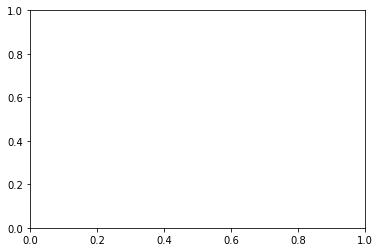

In [42]:
fig, ax = plt.subplots()
ax.plot(pred[10])
Audio(pred[10], rate=sr)